In [1]:
import prepare
import wrangle
import os
import time
import unicodedata
import re
import json
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings("ignore")

In [2]:
# To start I made a function named github_ac_urls() which scrapes github for the name of the repositories, 
# then I ran Zach's acquire function to get the repo information and contents
# finally, I converted it to a csv to make it easier (and FASTER) to load
# There were 873 repositories to begin with
df= pd.read_csv('animal_crossing.csv', index_col=0)

# Prep 

In [3]:
#After running Zach's acquire function, apparently only 30/873 repos are not empty
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30 entries, 0 to 29
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             30 non-null     object
 1   language         29 non-null     object
 2   readme_contents  27 non-null     object
dtypes: object(3)
memory usage: 960.0+ bytes


In [4]:
#finding the length of the readme
df['readme_length'] = wrangle.find_readme_length()

In [5]:
# finding the amount of nulls per column
df.isnull().sum()

repo               0
language           1
readme_contents    3
readme_length      0
dtype: int64

In [6]:
#visualzing the nulls
df[df.repo.isnull()]

,repo,language,readme_contents,readme_length


In [7]:
#visualzing the nulls
df[df.language.isnull()]

,repo,language,readme_contents,readme_length
15,chuangmaster/AnimalCrossingLineBotUpdateDoc,NaN,# AnimalCrossingLineBotUpdateDoc\n此為「集合啦！動物森友會...,5835


In [8]:
#visualzing the nulls
df[df.readme_contents.isnull()]

,repo,language,readme_contents,readme_length
4,seanpm2001/Mammal_Town,Python,NaN,3
11,Chriskeehk/Animal-Crossing,HTML,NaN,3
25,custardplanet/villager-bot,Python,NaN,3


In [9]:
#removing the nulls
df.dropna(inplace=True)

In [10]:
#sanity checking
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26 entries, 0 to 29
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             26 non-null     object
 1   language         26 non-null     object
 2   readme_contents  26 non-null     object
 3   readme_length    26 non-null     int64 
dtypes: int64(1), object(3)
memory usage: 1.0+ KB


In [11]:
def clean(text):
    '''This function cleans up the text data from the readme_contents.'''
    wnl = nltk.stem.WordNetLemmatizer()
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words]

In [12]:
#clean to hold the normalized and tokenized original with the stopwords removed.
df['clean'] = df['readme_contents'].apply(lambda x: prepare.remove_stopwords(prepare.tokenize(prepare.basic_clean(x))))
#stemmed to hold the stemmed version of the cleaned data.
df['stemmed'] = df['clean'].apply(lambda x: prepare.stem(x))
#lemmatized to hold the lemmatized version of the cleaned data.
df['lemmatized'] = df['clean'].apply(lambda x: prepare.lemmatize(x))
df

,repo,language,readme_contents,readme_length,clean,stemmed,lemmatized
0,TuckingFypos/turnip-price-tracker,Python,# Turnip Price Tracker\n> A Discord bot for Th...,2304,turnip price tracker discord bot theleague40 t...,turnip price tracker discord bot theleague40 t...,turnip price tracker discord bot theleague40 t...
1,HxBreak/AnimalCrossingTools-Android,Kotlin,# Animal Crossing Tools - Android\n\n## descri...,597,animal crossing tools android description tool...,anim cross tool android descript tool helper p...,animal crossing tool android description tool ...
2,stellaw1/fellow-crossing,C++,"<p align=""center""> <img src=""https://imgur.com...",2258,p aligncenter img srchttpsimgurcomd4drrsopng a...,p aligncent img srchttpsimgurcomd4drrsopng ali...,p aligncenter img srchttpsimgurcomd4drrsopng a...
3,mutoo/critterpedia-plus,JavaScript,# Critterpedia-plus\n\nAn advanced critterpedi...,1026,critterpediaplus advanced critterpedia animal ...,critterpediaplu advanc critterpedia anim cross...,critterpediaplus advanced critterpedia animal ...
5,Maxzilla60/AC-Lister,TypeScript,# Animal Crossing ★ Villager Lister\nEasily se...,2453,animal crossing villager lister easily search ...,anim cross villag lister easili search view as...,animal crossing villager lister easily search ...
6,jamchamb/ac-nesrom-save-generator,Python,# ac-nesrom-save-generator\n\n## Setup\n\nUse ...,2926,acnesromsavegenerator setup use pip install de...,acnesromsavegener setup use pip instal depend ...,acnesromsavegenerator setup use pip install de...
7,HarrisonXi/AnimalCrossingFlower,Python,# 《动物森友会》蓝玫瑰花卉杂交无歧义优化方案\n\n### 引用资料\n\nGoogle文...,5427,google animal crossing flower genetics guideht...,googl anim cross flower genet guidehttpsdocsgo...,google animal crossing flower genetics guideht...
8,NWPlayer123/AnimalCrossing,C,# Animal Crossing for Nintendo GameCube\r\n\r\...,194,animal crossing nintendo gamecube repository b...,anim cross nintendo gamecub repositori basic s...,animal crossing nintendo gamecube repository b...
9,dragos240/Pocket-NLSE,C,# Pocket-NLSE\nA portable save editor for Anim...,361,pocketnlse portable save editor animal crossin...,pocketnls portabl save editor anim cross new l...,pocketnlse portable save editor animal crossin...
10,SeunghoShin93/Animal-Crossing-Finder-Crawler-,Python,# Animal Crossing Finder (Crawler)\n\n## 프로젝트 ...,1520,animal crossing finder crawler getting started...,anim cross finder crawler get start pip upgrad...,animal crossing finder crawler getting started...


# Explore 

In [13]:
#visualizing the amount of languages
df.language.value_counts()

JavaScript          8
Python              6
C                   2
TypeScript          2
C#                  2
Vue                 1
Swift               1
Jupyter Notebook    1
Kotlin              1
Dart                1
C++                 1
Name: language, dtype: int64

[Text(0, 0.5, 'Number of Repos'),
 Text(0.5, 0, 'Name of Repo'),
 Text(0.5, 1.0, 'Distribution of Coding Languages in Animal Crossing Github Repos')]

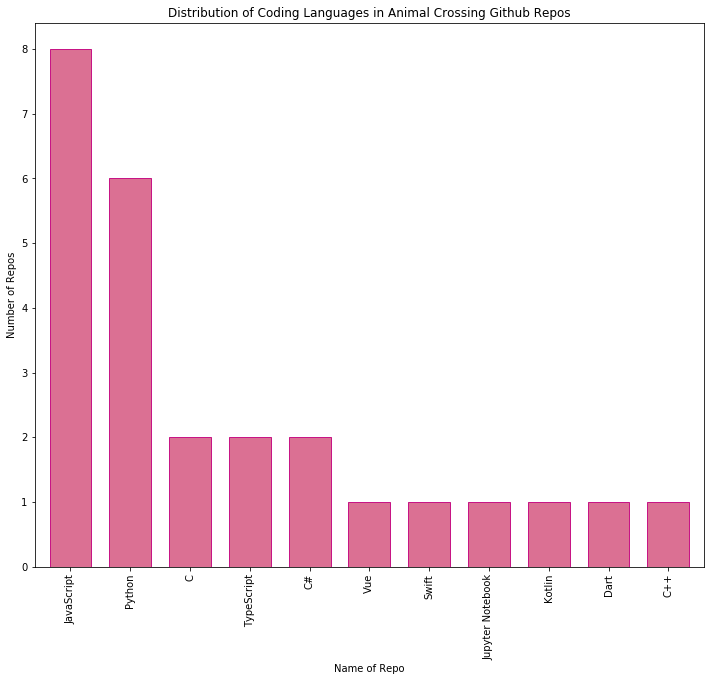

In [14]:
fig = plt.figure(figsize=(12, 10))

ax = df.language.value_counts().plot.bar(width=.7, ec='mediumvioletred', color='palevioletred')
ax.set(title='Distribution of Coding Languages in Animal Crossing Github Repos', ylabel='Number of Repos', xlabel='Name of Repo')

In [15]:
#limit dataframe to the top 5 languages
top_5_languages = df.language.value_counts().index[0:5]

In [16]:
df_5 = df[df.language.isin(top_5_languages)]
df_5

,repo,language,readme_contents,readme_length,clean,stemmed,lemmatized
0,TuckingFypos/turnip-price-tracker,Python,# Turnip Price Tracker\n> A Discord bot for Th...,2304,turnip price tracker discord bot theleague40 t...,turnip price tracker discord bot theleague40 t...,turnip price tracker discord bot theleague40 t...
3,mutoo/critterpedia-plus,JavaScript,# Critterpedia-plus\n\nAn advanced critterpedi...,1026,critterpediaplus advanced critterpedia animal ...,critterpediaplu advanc critterpedia anim cross...,critterpediaplus advanced critterpedia animal ...
5,Maxzilla60/AC-Lister,TypeScript,# Animal Crossing ★ Villager Lister\nEasily se...,2453,animal crossing villager lister easily search ...,anim cross villag lister easili search view as...,animal crossing villager lister easily search ...
6,jamchamb/ac-nesrom-save-generator,Python,# ac-nesrom-save-generator\n\n## Setup\n\nUse ...,2926,acnesromsavegenerator setup use pip install de...,acnesromsavegener setup use pip instal depend ...,acnesromsavegenerator setup use pip install de...
7,HarrisonXi/AnimalCrossingFlower,Python,# 《动物森友会》蓝玫瑰花卉杂交无歧义优化方案\n\n### 引用资料\n\nGoogle文...,5427,google animal crossing flower genetics guideht...,googl anim cross flower genet guidehttpsdocsgo...,google animal crossing flower genetics guideht...
8,NWPlayer123/AnimalCrossing,C,# Animal Crossing for Nintendo GameCube\r\n\r\...,194,animal crossing nintendo gamecube repository b...,anim cross nintendo gamecub repositori basic s...,animal crossing nintendo gamecube repository b...
9,dragos240/Pocket-NLSE,C,# Pocket-NLSE\nA portable save editor for Anim...,361,pocketnlse portable save editor animal crossin...,pocketnls portabl save editor anim cross new l...,pocketnlse portable save editor animal crossin...
10,SeunghoShin93/Animal-Crossing-Finder-Crawler-,Python,# Animal Crossing Finder (Crawler)\n\n## 프로젝트 ...,1520,animal crossing finder crawler getting started...,anim cross finder crawler get start pip upgrad...,animal crossing finder crawler getting started...
12,helmasaur/ac-keijiban,JavaScript,[![License: MIT](https://img.shields.io/badge/...,2608,license mithttpsimgshieldsiobadgelicensemityel...,licens mithttpsimgshieldsiobadgelicensemityell...,license mithttpsimgshieldsiobadgelicensemityel...
13,artpark/AnimalCrossingUnity,C#,# AnimalCrossingUnity,21,animalcrossingunity,animalcrossingun,animalcrossingunity


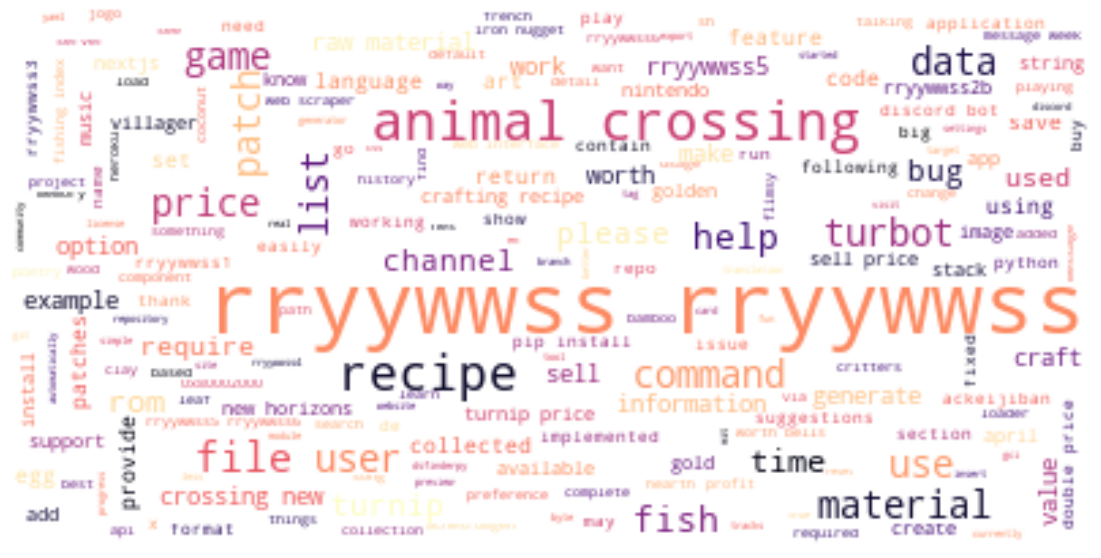

In [17]:
#finding top words used in readmes in the top 5 languages
img = WordCloud(background_color='white', colormap='magma_r').generate(' '.join(df_5['clean']))
plt.figure(figsize=[20,10])
plt.imshow(img, interpolation='bilinear')
plt.axis("off")
plt.show()


In [18]:
df_5.language.value_counts()

JavaScript    8
Python        6
C             2
TypeScript    2
C#            2
Name: language, dtype: int64

In [19]:
#use clean function to create six sets of data: Javascript, Python, C, TypeScript, C# and rejoin lemmatized words to one string
jscript_words = clean(' '.join(df.lemmatized[df.language == 'JavaScript']))
python_words = clean(' '.join(df.lemmatized[df.language == 'Python']))
c_words = clean(' '.join(df.lemmatized[df.language == 'C']))
typescript_words = clean(' '.join(df.lemmatized[df.language == 'TypeScript']))
c_sharp_words = clean(' '.join(df.lemmatized[df.language == 'C#']))


In [20]:
#finding most common bigrams in jscript words
top_10_jscript_bigrams = (pd.Series(nltk.ngrams(jscript_words, 2))
                      .value_counts()
                      .head(10))

top_10_jscript_bigrams.head()

(animal, crossing)     17
(message, week)         4
(fishing, index)        4
(const, ackeijiban)     3
(wild, world)           3
dtype: int64

In [21]:
#finding most common bigrams in python words
top_10_python_bigrams = (pd.Series(nltk.ngrams(python_words, 2))
                      .value_counts()
                      .head(10))

top_10_python_bigrams.head()

(rryywwss, rryywwss)    75
(rryywwss, 250)         18
(250, rryywwss)         13
(animal, crossing)      12
(raw, material)          8
dtype: int64

In [22]:
#finding most common bigrams in c words
top_10_c_bigrams = (pd.Series(nltk.ngrams(c_words, 2))
                      .value_counts()
                      .head(10))

top_10_c_bigrams.head()

(animal, crossing)        2
(issue, section)          2
(use, issue)              1
(file, case)              1
(pocketnlse, portable)    1
dtype: int64

In [23]:
#finding most common bigrams in typescript words
top_10_typescript_bigrams = (pd.Series(nltk.ngrams(typescript_words, 2))
                      .value_counts()
                      .head(10))

top_10_typescript_bigrams.head()

(animal, crossing)       3
(acqr, inpng)            3
(crossing, villager)     2
(easily, search)         2
(specie, personality)    2
dtype: int64

In [24]:
#finding most common bigrams in C# words
top_10_c_sharp_bigrams = (pd.Series(nltk.ngrams(c_sharp_words, 2))
                      .value_counts()
                      .head(10))

top_10_c_sharp_bigrams.head()

(animal, crossing)                            1
(animalcrossingunity, animal)                 1
(animalcrossingunity, animalcrossingunity)    1
(crossing, fanproject)                        1
dtype: int64

# Model

### establish a baseline

In [25]:
baseline = pd.DataFrame(df.language)
baseline['baseline'] = 'JavaScript'

In [26]:
baseline

,language,baseline
0,Python,JavaScript
1,Kotlin,JavaScript
2,C++,JavaScript
3,JavaScript,JavaScript
5,TypeScript,JavaScript
6,Python,JavaScript
7,Python,JavaScript
8,C,JavaScript
9,C,JavaScript
10,Python,JavaScript


### establish baseline accuracy

In [27]:
baseline_accuracy = round((baseline.language == baseline.baseline).mean(),2)
baseline_accuracy

0.31

### Split the data for modeling

In [28]:
train, validate, test = prepare.split(df)
train.shape, validate.shape, test.shape

((14, 7), (6, 7), (6, 7))

In [29]:
# setup X-train, validate and test variables
X_train = train.lemmatized
X_validate = validate.lemmatized
X_test = test.lemmatized

# setup y-train, validate and test variables
y_train = train.language
y_validate = validate.language
y_test = test.language

In [30]:
X_train.shape, X_validate.shape, X_test.shape

((14,), (6,), (6,))

In [31]:
y_train.shape, y_validate.shape, y_test.shape

((14,), (6,), (6,))


### Vectorizing data 

In [32]:
# Create the tfidf vectorizer object
# Step 1: create tf-idf value for each word, for each lemmatized readme
# Step 2: encode these values for use on models that only work on numbers, like classifications model
tfidf = TfidfVectorizer()

# Fit on the training data
tfidf.fit(X_train)

# Use the object
X_train_vectorized = tfidf.transform(X_train)
X_validate_vectorized = tfidf.transform(X_validate)
X_test_vectorized = tfidf.transform(X_test)

### Linear Regression

In [33]:
# Create logistic regression object -- to use on vectorized data
lm = LogisticRegression()

# Fit the classification model on our vectorized train data
lm.fit(X_train_vectorized, y_train)

LogisticRegression()

In [34]:
#create dataframes of actual values
train = pd.DataFrame(dict(actual=y_train))
validate = pd.DataFrame(dict(actual=y_validate))
test = pd.DataFrame(dict(actual=y_test))

# Use the trained model to predict y given those vectorized inputs of X
train['predicted'] = lm.predict(X_train_vectorized)
validate['predicted'] = lm.predict(X_validate_vectorized)
test['predicted'] = lm.predict(X_test_vectorized)

In [35]:
# Train Accuracy
train_accuracy = round((train.actual == train.predicted).mean(),3)
# Validate Accuracy
validate_accuracy = round((validate.actual == validate.predicted).mean(),3)
train_accuracy, validate_accuracy

(0.571, 0.5)

In [36]:
#begin building a dataframe to record accuracy
metric_df = pd.DataFrame(data=[{
    'model': 'logistic regression', 
    'baseline_accuracy': round(baseline_accuracy,3),
    'train_accuracy': round(train_accuracy, 3),
    'validate_accuracy': round(validate_accuracy, 3)}])
metric_df

,model,baseline_accuracy,train_accuracy,validate_accuracy
0,logistic regression,0.31,0.571,0.5


### K Nearest Neighbor

In [37]:
# Create the object
knn = KNeighborsClassifier(n_neighbors=4, weights='uniform')

#Fit the model
knn.fit(X_train_vectorized, y_train)

KNeighborsClassifier(n_neighbors=4)

In [38]:
#Make predictions on train
y_train_pred = knn.predict(X_train_vectorized)

#Estimate probability
y_train_pred_proba = knn.predict_proba(X_train_vectorized)

#Evaluate on accuracy
print('Accuracy of KNN classifier on training set: {:.3f}'
     .format(knn.score(X_train_vectorized, y_train)))
# assign accuracy to variable to call later
knn_train_accuracy = knn.score(X_train_vectorized, y_train)


Accuracy of KNN classifier on training set: 0.500


In [39]:
#Make predictions on validate
y_validate_pred = knn.predict(X_validate_vectorized)

#Estimate probability
y_validate_pred_proba = knn.predict_proba(X_validate_vectorized)

#Evaluate on accuracy
print('Accuracy of KNN classifier on validate set: {:.3f}'
     .format(knn.score(X_validate_vectorized, y_validate)))

# assign accuracy to variable to call later
knn_validate_accuracy = round(knn.score(X_validate_vectorized, y_validate),3)


Accuracy of KNN classifier on validate set: 0.167


In [40]:
#append dataframe to compare accuracy
metric_df = metric_df.append({
    'model': 'K-Nearest Neighbor', 
    'baseline_accuracy': baseline_accuracy,
    'train_accuracy': round(knn_train_accuracy,3),
    'validate_accuracy': knn_validate_accuracy}, ignore_index=True)
metric_df

,model,baseline_accuracy,train_accuracy,validate_accuracy
0,logistic regression,0.31,0.571,0.500
1,K-Nearest Neighbor,0.31,0.500,0.167


### Random Forest Classifier

In [41]:
#Create the model
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=3, 
                            random_state=123)
#Fit the model
rf.fit(X_train_vectorized, y_train)

RandomForestClassifier(max_depth=3, min_samples_leaf=3, random_state=123)

In [42]:
#Make predictions on train
y_train_pred = rf.predict(X_train_vectorized)
y_validate_pred = rf.predict(X_validate_vectorized)

#Estimate the probability
y_train_pred_proba = rf.predict_proba(X_train_vectorized)
y_validate_pred_proba = rf.predict_proba(X_validate_vectorized)

print('Accuracy of random forest classifier on training set: {:.3f}' .format(rf.score(X_train_vectorized, y_train)))
#make accuracy into a variable that can be called later
rf_train_accuracy = round(rf.score(X_train_vectorized, y_train),3)

Accuracy of random forest classifier on training set: 0.500


In [43]:
print(confusion_matrix(y_train, y_train_pred))

[[0 0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 4 0 0 0 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 1 0 0 3 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0 0]]


In [44]:
print(classification_report(y_train, y_train_pred))

                  precision    recall  f1-score   support

             C++       0.00      0.00      0.00         1
            Dart       0.00      0.00      0.00         1
      JavaScript       0.50      1.00      0.67         4
Jupyter Notebook       0.00      0.00      0.00         1
          Kotlin       0.00      0.00      0.00         1
          Python       0.50      0.75      0.60         4
      TypeScript       0.00      0.00      0.00         1
             Vue       0.00      0.00      0.00         1

        accuracy                           0.50        14
       macro avg       0.12      0.22      0.16        14
    weighted avg       0.29      0.50      0.36        14



In [45]:

#Check accuracy on validate
print('Accuracy of random forest classifier on validate set: {:.3f}'
     .format(rf.score(X_validate_vectorized, y_validate)))

rf_validate_accuracy = round(rf.score(X_validate_vectorized, y_validate),3)

Accuracy of random forest classifier on validate set: 0.333


In [46]:
#append dataframe to compare accuracy
metric_df = metric_df.append({
    'model': 'random_forest', 
    'baseline_accuracy': baseline_accuracy,
    'train_accuracy': rf_train_accuracy,
    'validate_accuracy': rf_validate_accuracy}, ignore_index=True)
metric_df

,model,baseline_accuracy,train_accuracy,validate_accuracy
0,logistic regression,0.31,0.571,0.500
1,K-Nearest Neighbor,0.31,0.500,0.167
2,random_forest,0.31,0.500,0.333


## Model on Test Data

In [47]:
#Make predictions in test
y_test_pred = lm.predict(X_test_vectorized)
#Estimate probability
y_test_pred_proba = lm.predict_proba(X_test_vectorized)
#Evaluate on accuracy
print('Accuracy of lm classifier on test set: {:.3f}'
     .format(lm.score(X_test_vectorized, y_test)))
#make accuracy into a variable that can be called later
lm_test_accuracy = lm.score(X_test_vectorized, y_test)

Accuracy of lm classifier on test set: 0.333


# Conclusion 